Code cleaup. Need to 
1. remove repeated sentences due to vtt formatting
2. some words are concatenated together (helloBut--> hello But, swimming in a pool.We--> swimming in a pool. We)

In [106]:
import glob
import json
import regex as re
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus.reader import *
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiwonlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiwonlee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [107]:
with open('../channelHolisticInfo.json', 'r') as j:
    channelHolisticInfo = json.loads(j.read())
channelHolisticInfoDf = pd.DataFrame.from_dict(channelHolisticInfo)
channelHolisticInfoDf.head()

,channelName,channelId,daysLiveAsOfLaunch,daysSinceFirstVideo,description,viewCount,subscriberCount,videoCount,firstUploadDate,subscribersPerYearSinceFirstUpload,viewCountPerYearSinceFirstUpload
0,Alex Clark,UCsDmESjqNPukDmVnuneLrqw,4392,4389,"Funny vids about my life. I'm thankful for the community that's been here for over a decade. \n\nI've been making videos since 2009. \n\n\n\n\nStarted on Dec 7, 2009\n****",471903125,4280000,317,2009-12-07T21:13:28Z,355935.292777,3.924462e+07
1,Alex Meyers,UCY6Ij8zOds0WJEeqCLOnqOQ,2348,2341,"I make cartoons and sometimes video essays about movies and TV Shows mostly, but sometimes I tell stories about my weird life.\n\nMy dog Charlie is the cutest dog in the world, fyi.\n\nFollow me on Twitter: https://twitter.com/judgeofthekings\n\nFollow my dog Charlie on Instagram: https://www.instagram.com/charlie_meets_pumpkin\n\nFor fan mail, email me at: alexmeyerscontact (at) gmail.com",472627239,2870000,256,2015-07-18T11:43:37Z,447479.709526,7.369028e+07
2,WowRightMeow,UClN24S5-fc7LD0JJW0FdGWw,1946,1809,"Yo! I'm Jamie, a dorky human from Wales. Did a degree in animation, worked in industry, and now I'm here 🤟\n\nSoftware/Hardware I use:\nAnimation Software: Animate CC, Photoshop CC\nEditing: Premiere Pro CC, After Effects CC\nAudio: Audition CC\nAdditional illustration: Photoshop CC, Procreate (on iPad, using a Mark II iPad Pro w. original apple pencil)\n\nDrawing Tablet: Wacom Cintiq 24""",29732357,537000,33,2016-12-31T15:08:07Z,108349.917081,5.999066e+06
3,Andrei Terbea,UC3iNdSV_RQU7DHTGpqEW96w,3147,3149,"Doing animated commentary and solving crimes with my purple goose boi Wilfur!\n\nI animate using Adobe Flash CS6, with a Wacom Intuos Pro M tablet.",292193694,2860000,136,2013-04-30T20:01:32Z,331502.064147,3.386812e+07
4,Billy But Better,UC_52i6mlrzOZs_NEuSepzAg,2805,1736,"Yes, it's a foot.\n\nSocial Medias:\nTwitter - https://www.twitter.com/BillyButBetter\nInstagram - https://www.instagram.com/billybutbetterofficial\n\n\nThings I use to make videos:\nI use a Blue Yeti Microphone - http://amzn.to/2sb6qhM\nI use a Huion KAMVAS GT-156 v 2 Drawing Monitor - http://amzn.to/2FnCqHT\nI use Adobe Premiere Pro CC to edit - http://amzn.to/2tKazLD\nI use Paint Tool Sai 2 to draw\nI use Levelator to make the audio balanced",12166120,260000,23,2017-03-14T02:31:14Z,54665.898618,2.557969e+06


In [108]:
LIST_OF_CHANNEL_IDS = channelHolisticInfoDf['channelId'].tolist()
LIST_OF_CHANNEL_NAMES = channelHolisticInfoDf['channelName'].tolist()
LIST_OF_VIDEO_COUNT = channelHolisticInfoDf['videoCount'].tolist()

In [110]:
def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        duplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            duplicatedLinesList.append(strippedLines[index])
    return [i for n, i in enumerate(duplicatedLinesList) if i not in duplicatedLinesList[:n]]
# print(generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt"))

def generateListOfWords(listOfSentences):
    all_stopwords = list(stopwords.words('english'))
    cleanedListOfWords = []
    for words in listOfSentences:
        word = re.split('[?."(),!) ]', words)
        for wo in word:
            if wo !='' and wo not in all_stopwords:
                cleanedListOfWords.append(wo)
    return cleanedListOfWords

def flattenList(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

#wordCloud[channelId] = all words from all .txt files with no stopwords
#sentenceCloud[channelId] = all sentences from all .txt files.

wordCloud = {}
sentenceCloud = {}
for channelId in LIST_OF_CHANNEL_IDS:
    listOfSentences = []
    listOfWords = []
    print(channelId, "has ", len(glob.glob(channelId+"/txt/*.txt")), "files to process.")
    for txtFilePath in glob.glob(channelId+"/txt/*.txt"):
        listOfSentences.append(generateListOfSentences(txtFilePath))
    flattenedListOfSentences = flattenList(listOfSentences) #<--
    flattendListOfWords = generateListOfWords(flattenedListOfSentences)

    sentenceCloud[channelId.split('/')[0]] = flattenedListOfSentences
    wordCloud[channelId.split('/')[0]] = flattendListOfWords
    print(channelId.split('/')[0], ": ", len(flattenedListOfSentences), "sentences total")
    print(channelId.split('/')[0], ": ", len(flattendListOfWords), "words total")

    with open(channelId.split('/')[0]+"_wordCloud.txt", 'w') as f:
        json.dump(flattendListOfWords, f)
    with open(channelId.split('/')[0]+"_sentenceCloud.txt", 'w') as f:
        json.dump(flattenedListOfSentences, f)

UCsDmESjqNPukDmVnuneLrqw has  298 files to process.
UCsDmESjqNPukDmVnuneLrqw :  35495 sentences total
UCsDmESjqNPukDmVnuneLrqw :  155629 words total
UCY6Ij8zOds0WJEeqCLOnqOQ has  250 files to process.
UCY6Ij8zOds0WJEeqCLOnqOQ :  81861 sentences total
UCY6Ij8zOds0WJEeqCLOnqOQ :  315581 words total
UClN24S5-fc7LD0JJW0FdGWw has  27 files to process.
UClN24S5-fc7LD0JJW0FdGWw :  5582 sentences total
UClN24S5-fc7LD0JJW0FdGWw :  20194 words total
UC3iNdSV_RQU7DHTGpqEW96w has  112 files to process.
UC3iNdSV_RQU7DHTGpqEW96w :  19042 sentences total
UC3iNdSV_RQU7DHTGpqEW96w :  76439 words total
UC_52i6mlrzOZs_NEuSepzAg has  23 files to process.
UC_52i6mlrzOZs_NEuSepzAg :  2594 sentences total
UC_52i6mlrzOZs_NEuSepzAg :  11450 words total
UCr3cBLTYmIK9kY0F_OdFWFQ has  80 files to process.
UCr3cBLTYmIK9kY0F_OdFWFQ :  9538 sentences total
UCr3cBLTYmIK9kY0F_OdFWFQ :  37907 words total
UCV6g95OBbVtFmN9uiJzkFqQ has  223 files to process.
UCV6g95OBbVtFmN9uiJzkFqQ :  11338 sentences total
UCV6g95OBbVtFm

In [105]:
#Actually create sentences. Not chunks. 

def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        removeDuplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            removeDuplicatedLinesList.append(strippedLines[index])
        removeDuplicatedLinesList =[i for n, i in enumerate(removeDuplicatedLinesList) if i not in removeDuplicatedLinesList[:n]]
        # print(removeDuplicatedLinesList)
        passage = " ".join(removeDuplicatedLinesList)
        print(passage)
        # passageIntoSentences= split_into_sentences(str(passage))
        # print(passageIntoSentences)
    return [i for n, i in enumerate(removeDuplicatedLinesList) if i not in removeDuplicatedLinesList[:n]]

generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt")

you know what's really common when art teachers in either junior high or high school for whatever reason have this absolute burning hate for anime style art I have met so many art teachers throughout my teenage years that would always go really snobby like it's not even real art err old Thanks thank you for that and whenever I heard this as a young and developing kid who was interested in art whose primary inspiration was anime that was just discouraging why would you be in our teacher if you're going to do that I know right as a medium of entertainment anime has always been one of my Holy Grails it can be either funny or inspiring heartfelt or relatable but regardless at its core it's just downright entertaining and in a lot of cases has even helped me connect with others and make a lot of new friends so you already know I gotta represent my boy anime I couldn't just let some random art teacher talk that smack about my favorite thing now unfortunately I couldn't just talk back to thes

["you know what's really common when art",
 'teachers in either junior high or high',
 'school for whatever reason have this',
 'absolute burning hate for anime style',
 'art I have met so many art teachers',
 'throughout my teenage years that would',
 "always go really snobby like it's not",
 'even real art err old Thanks',
 'thank you for that and whenever I heard',
 'this as a young and developing kid who',
 'was interested in art whose primary',
 'inspiration was anime that was just',
 'discouraging why would you be in our',
 "teacher if you're going to do that I",
 'know right as a medium of entertainment',
 'anime has always been one of my Holy',
 'Grails it can be either funny or',
 'inspiring heartfelt or relatable but',
 "regardless at its core it's just",
 'downright entertaining and in a lot of',
 'cases has even helped me connect with',
 'others and make a lot of new friends so',
 'you already know I gotta represent my',
 "boy anime I couldn't just let some",
 'random art t

Unfortunately, VADER works on sentences and what I have are fragments due to the nature of transcripts. I also tried simply detecting sentences in a punctuation-less passage but I think that takes a system that has a very good understanding of grammar and speech. There is a way to use NLTK to detect sentences in a passage if it has punctuation, but that case is straightforward.
As seen above, without punctuations to dictate where a sentence starts and ends, it's difficult to really know how to divide it up. So I'm just going to have to accept this shortcoming. For now.

# Holistically

33


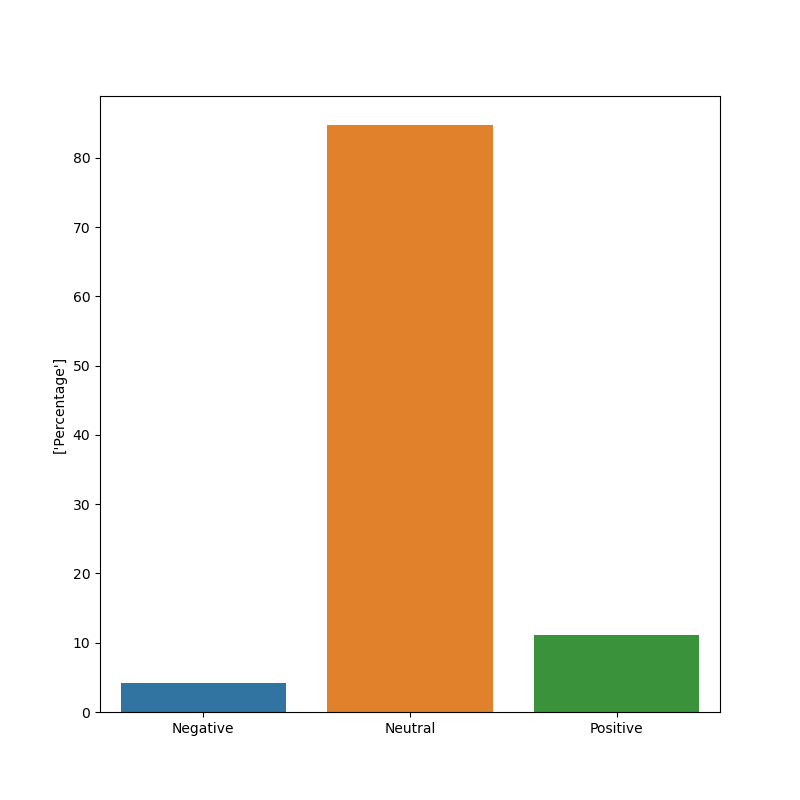

,neg,neu,pos,compound,words,label
0,0.0,0.0,0.0,0.0000,I,0
1,1.0,0.0,0.0,-0.3182,lost,-1
2,0.0,1.0,0.0,0.0000,suitcase,0
3,0.0,1.0,0.0,0.0000,Riding,0
4,0.0,1.0,0.0,0.0000,runaway,0


In [111]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

print(len(wordCloud.keys()))
for channelId in LIST_OF_CHANNEL_IDS:
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

In [112]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,words,label
1,1.0,0.0,0.0,-0.3182,lost,-1
29,1.0,0.0,0.0,-0.1027,Nah,-1
30,1.0,0.0,0.0,-0.1027,nah,-1
31,1.0,0.0,0.0,-0.1027,nah,-1
32,1.0,0.0,0.0,-0.1027,nah,-1


In [113]:
print(df_positive_negative.label.value_counts())

 1    224624
-1     85038
Name: label, dtype: int64


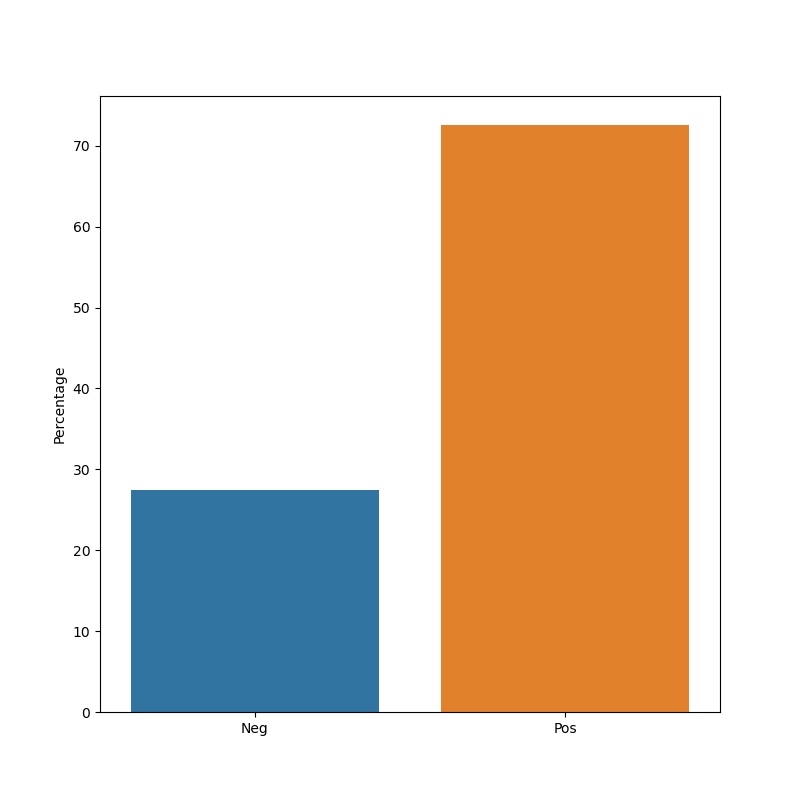

In [114]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

Basically, compared to redditors, animation youtubers are more 'positive'

# By Channel by words

In [115]:
channelId_to_df = {}
sia = SIA()
for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_df[channelId] = df
df[150:200]

,neg,neu,pos,compound,words
150,0.0,1.0,0.0,0.0000,symmetry
151,0.0,1.0,0.0,0.0000,We
152,0.0,1.0,0.0,0.0000,can't
153,0.0,0.0,1.0,0.3400,play
154,0.0,0.0,1.0,0.2732,God
155,0.0,1.0,0.0,0.0000,Michael
156,0.0,0.0,1.0,0.2732,God
157,0.0,1.0,0.0,0.0000,meter
158,0.0,1.0,0.0,0.0000,maid
159,0.0,1.0,0.0,0.0000,AND


In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generateWordCloud(pos_words_str, neg_words_str):
    wordcloud_positive = WordCloud(background_color='white').generate(pos_words_str)
    wordcloud_negative = WordCloud().generate(neg_words_str)

    plt.imshow(wordcloud_positive, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.imshow(wordcloud_negative, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [117]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_df[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].words)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].words)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
print(scores)

{'UCsDmESjqNPukDmVnuneLrqw': 0.03598800095098057, 'UCY6Ij8zOds0WJEeqCLOnqOQ': 0.03490942578925728, 'UClN24S5-fc7LD0JJW0FdGWw': 0.03125584827176393, 'UC3iNdSV_RQU7DHTGpqEW96w': 0.01964876306597451, 'UC_52i6mlrzOZs_NEuSepzAg': 0.026322620087336185, 'UCr3cBLTYmIK9kY0F_OdFWFQ': 0.022758392908961648, 'UCV6g95OBbVtFmN9uiJzkFqQ': 0.02303998159520771, 'UCgCKYs56-LKEPGQ99DzqQOg': 0.03185890931045172, 'UCOwxx9VnEnlFKt5EB70KTzQ': 0.020200437534182554, 'UC2Ds30pkifFVD0CE08wF50g': 0.023626946681174984, 'UC7UGbBVrqLlq6CRxWWUmyKw': 0.01929805126873668, 'UCn1XB-jvmd9fXMzhiA6IR0w': 0.03001827003460854, 'UCFeqAfEuKm7lIg2ddQzh61A': 0.037586993545588886, 'UCAlxwHEm1bWWYoe5VCSQYEg': 0.03718808725854706, 'UCz7iJPVTBGX6DNO1RNI2Fcg': 0.006994170265268334, 'UCOAUz4d1NUNxSHh_SOJtdGQ': 0.032202814022628694, 'UCGGTAB19HlHEWPwwmxHsEKA': 0.029578237764072896, 'UCOsATJw-IZgqGT8MFrHjKGg': 0.03347047930283211, 'UCsKVP_4zQ877TEiH_Ih5yDQ': 0.02886641732407261, 'UCOinp9hALPUcZeoL3Kmaviw': 0.03012908285527542, 'UCGwu0nbY2

# By sentences

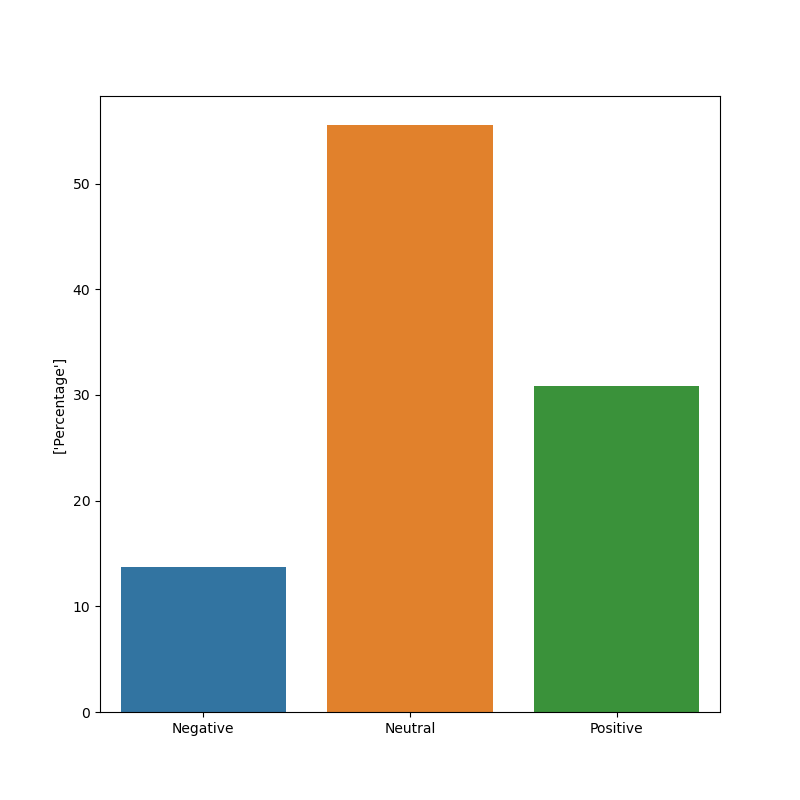

,neg,neu,pos,compound,sentence,label
0,0.535,0.465,0.0,-0.3182,I lost my suitcase,-1
1,0.000,1.000,0.0,0.0000,Riding on a runaway train,0
2,0.000,1.000,0.0,0.0000,Got sunburned dancing waiting for the evening rain,0
3,0.000,1.000,0.0,0.0000,"When I was resting, it only washed into my skin",0
4,0.000,1.000,0.0,0.0000,"And when I woke up, dawn was starting to begin",0


In [118]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for channelId in LIST_OF_CHANNEL_IDS:
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

# By channel by sentences

In [119]:
sentenceCloud[LIST_OF_CHANNEL_IDS[28]]

['This story takes place in a church basement. (Yikes)',
 "Yeah I know that's a real beautiful way to start.",
 'Sounds shady as...',
 'heaven? (take that, demonetization)',
 'But it is what it is.',
 'I was 9 at the time. (still a fetus)',
 'Fresh out of Walmart,',
 'and there was this squad I always used to hang out with.',
 'These were the rugrat friends I grew up alongside and the ones who were willing to go through',
 'all the crazy shenanigans on our bucket list.(little hooligans)',
 'So let me give you a brief introduction to these guys.',
 'This was "Afro", the oldest and toughest of the bunch',
 '*scary-ish grunt*',
 'He looks like a Geodude with an afro.',
 'This is Jaws, the hyper kid whose body was made of 75% sugar instead of water. (wtf)',
 "I'm telling you this kid could be chasing cars one second,",
 'and then doing the Funky Chicken on a rooftop the next. (wtf)',
 "I'm afraid the day he tries Red Bull. (RUN)",
 'This is "Gal."',
 'The sassy hipster "Yaaas bitch!", icon

In [120]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
channelId_to_sentencedf = {}

for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_sentencedf[channelId] = df
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1


In [121]:
from IPython.display import display

for channelId in LIST_OF_CHANNEL_IDS:
    display(channelId_to_sentencedf[channelId][200:250])

,neg,neu,pos,compound,sentence
200,0.000,0.500,0.500,0.4588,my favorite mom-and-pop italian
201,0.000,1.000,0.000,0.0000,restaurants in the los angeles area
202,0.000,1.000,0.000,0.0000,frito misto and kolori kitchen they skip
203,0.000,0.667,0.333,0.3612,the [ __ ] with like the hoity-toity
204,0.000,0.545,0.455,0.3612,prices and they're like
205,0.000,1.000,0.000,0.0000,we don't serve bread we serve rolls plus
206,0.000,0.476,0.524,0.6705,i'm pretty sure i saw emma stone in
207,0.000,1.000,0.000,0.0000,calorie kitchen with andrew garfield
208,0.000,1.000,0.000,0.0000,when they were shooting spider-man
209,0.000,1.000,0.000,0.0000,and i think i may have witnessed the


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,"Anyway, skipping ahead a little bit"
201,0.000,1.000,0.000,0.0000,Renesnee has now grown up because she ages
202,0.000,1.000,0.000,0.0000,really fast for some mysterious reason
203,0.000,1.000,0.000,0.0000,and Bella's getting used to her new life of
204,0.000,1.000,0.000,0.0000,doing...
205,0.000,0.385,0.615,0.4939,pretty much nothing.
206,0.000,0.444,0.556,0.3612,I mean like really
207,0.000,0.809,0.191,0.2235,"they don't eat, they don't sleep, no one goes"
208,0.161,0.839,0.000,-0.2755,"to school anymore, it doesn't look like anyone has a job or anything,"
209,0.000,0.660,0.340,0.4740,So like what're you guys even doing?!


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,"Which in a few months, I'd learn a lasting life lesson from"
201,0.063,0.684,0.254,0.6542,"Cody was tall, slim, was subtly nerdy but also exceeded an air of confidence"
202,0.000,0.667,0.333,0.4588,More than anything he had cute hair
203,0.337,0.396,0.267,-0.1779,I was always a sucker for interesting hairstyles
204,0.000,1.000,0.000,0.0000,Despite him being in my year
205,0.000,1.000,0.000,0.0000,I'd never actually really seen him before
206,0.000,1.000,0.000,0.0000,This wasn't entirely uncommon with the way our year groups were splits
207,0.000,1.000,0.000,0.0000,But as we started talking we immediately hit it off
208,0.000,1.000,0.000,0.0000,Our task at the woodworking Club was to build birdhouses for the school grounds
209,0.000,0.855,0.145,0.2960,And of course me being me went above and beyond in creating some elaborate


,neg,neu,pos,compound,sentence
200,0.169,0.831,0.000,-0.0572,taking notes look I don't want to give
201,0.139,0.567,0.295,0.3352,them too much credit I don't want to
202,0.000,0.765,0.235,0.2846,encourage theft at any scale but the way
203,0.000,0.759,0.241,0.2263,this robbery took place is straight out
204,0.381,0.619,0.000,-0.5719,of a fast and furious movie according to
205,0.000,1.000,0.000,0.0000,Jeffrey the launch of Blue Blood was so
206,0.000,0.693,0.307,0.4767,ambitious and so large in scope that he
207,0.000,1.000,0.000,0.0000,had to spread out the units throughout
208,0.000,1.000,0.000,0.0000,his multiple warehouses to keep them
209,0.000,0.625,0.375,0.3400,secure we're talking over 1 million


,neg,neu,pos,compound,sentence
200,0.140,0.750,0.110,-0.1531,"I was just freaking karate chop that person's arm out of the way. Yeah, people thought I was a psychopath"
201,0.112,0.727,0.161,0.2235,But it wasn't my fault okay? When we left Middle school and started high school
202,0.000,1.000,0.000,0.0000,"I don't know how he did it, but somehow. He was able to make the acronym milf which stands for well... You can look it up"
203,0.000,1.000,0.000,0.0000,Become a very commonly used phrase in our school
204,0.000,1.000,0.000,0.0000,he would make all kinds of variations of the word a desk would become a dilf a
205,0.000,1.000,0.000,0.0000,Pencil would become a pencilf he even called me bilfy at one point
206,0.081,0.812,0.107,0.1779,There was no word in the English dictionary that was safe sooner or later everyone who knew shimada-san which was most people in school
207,0.000,0.690,0.310,0.7351,"He was a pretty popular guy, just started milfing up their sentences dang. I got really milfed by that test yesterday"
208,0.000,1.000,0.000,0.0000,"Hey, do you have any papilf? I can borrof are you going to prilf this year? Oh?"
209,0.000,1.000,0.000,0.0000,"What, prilf?"


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,replacement cartridges are sent for a
201,0.000,1.000,0.000,0.0000,few bucks a month we are talking about
202,0.000,1.000,0.000,0.0000,Razer cartridges again but I did for a
203,0.000,0.676,0.324,0.3400,second get excited that the butt-wipes
204,0.000,1.000,0.000,0.0000,came in a fully automatic magazine at
205,0.000,0.722,0.278,0.4019,any rate while they clearly need me on
206,0.000,1.000,0.000,0.0000,R&amp;D I have found my entire bathroom
207,0.000,1.000,0.000,0.0000,experience to actually be much more
208,0.000,1.000,0.000,0.0000,convenient because I don't have to
209,0.000,1.000,0.000,0.0000,remember to buy the little things I


,neg,neu,pos,compound,sentence
200,0.000,0.686,0.314,0.4939,hand I'm sponsored by Red Bull you know
201,0.000,0.619,0.381,0.5106,yeah go get a man ah all right well it
202,0.000,0.706,0.294,0.3612,seems like one of my teammates knows
203,0.000,1.000,0.000,0.0000,what they're I am never gonna level up
204,0.157,0.843,0.000,-0.0772,am i hey dude I'm sorry man I can't find
205,0.220,0.780,0.000,-0.3071,the enemy flag on this map but but we're
206,0.000,0.690,0.310,0.2023,playing team deathmatch wait a minute
207,0.485,0.515,0.000,-0.6908,that our team just get a kill
208,0.220,0.600,0.180,-0.1027,did the afk guy start playing no then
209,0.000,1.000,0.000,0.0000,then who was that man I'm never gonna


,neg,neu,pos,compound,sentence
200,0.688,0.312,0.000,-0.2960,"No, I don't."
201,0.000,1.000,0.000,0.0000,I learned
202,0.000,1.000,0.000,0.0000,Madz: mine from Mario
203,0.000,1.000,0.000,0.0000,Curt: bros.
204,0.000,0.000,1.000,0.2960,Yeah.
205,0.000,0.444,0.556,0.3612,And learning like
206,0.000,0.625,0.375,0.2023,flirting from Mario bros.
207,0.000,1.000,0.000,0.0000,This is the same guy whose girl keeps
208,0.000,1.000,0.000,0.0000,getting kidnapped with heavy air quotes.
209,0.783,0.217,0.000,-0.5574,Oh shit.


,neg,neu,pos,compound,sentence
200,0.000,0.872,0.128,0.2960,I forgot to mention that my dad actually made me take Taekwondo classes when I was younger yeah
201,0.085,0.666,0.248,0.4422,"Yeah, don't ask. I kinda accidentally made Chad cry, but this also earned me some cool points with all the kids"
202,0.000,0.853,0.147,0.4767,Eventually it started making friends because of well... Pokemon. I was literally the only girl in the group of kids
203,0.000,0.925,0.075,0.1779,"that would bring the game boys to school. All the other kids will play pokemon for money, but I would never have money"
204,0.235,0.765,0.000,-0.2850,So I can never join in the first place
205,0.000,0.917,0.083,0.1154,"Okay, maybe I spend my money on a couple bags of Doritos, but let's not talk about that either"
206,0.306,0.379,0.315,-0.1779,I'd like to say that I love competitive battling but in all honesty. I get too frustrated when I lose in games
207,0.224,0.776,0.000,-0.3818,"Anywho Z's in one of those battles. I remember a kid saying,"
208,0.000,1.000,0.000,0.0000,"""Aww, you have an Arcanine?"
209,0.097,0.627,0.276,0.3736,"Do you want to trade? Please? I would pay three dollars for that."""


,neg,neu,pos,compound,sentence
200,0.000,0.680,0.320,0.5106,encourage you to do the same although if
201,0.333,0.667,0.000,-0.3612,you are a naturally lazy person this
202,0.231,0.769,0.000,-0.2732,will make you feel a lot of guilt and
203,0.310,0.690,0.000,-0.4019,you probably get nagged a lot you know
204,0.000,1.000,0.000,0.0000,what let's just add another name to them
205,0.000,0.000,1.000,0.2263,okay
206,0.136,0.357,0.507,0.7351,the nagger but it's for the greater good
207,0.000,0.805,0.195,0.1154,the couchsurfers okay not all but but
208,0.000,1.000,0.000,0.0000,most of these guys will hit you with the
209,0.000,1.000,0.000,0.0000,I'm homeless right now


,neg,neu,pos,compound,sentence
200,0.000,0.761,0.239,0.2960,happened yeah what did Dan know the dude
201,0.000,1.000,0.000,0.0000,I didn't even talk to the dude I know
202,0.000,1.000,0.000,0.0000,what by showing up I managed to make
203,0.342,0.658,0.000,-0.3818,someone dislike me ganking mid I'm
204,0.000,1.000,0.000,0.0000,thinking what are you doing here this is
205,0.000,1.000,0.000,0.0000,really far from Italy I was watching
206,0.000,0.449,0.551,0.5994,youtubers while I play video games like
207,0.000,1.000,0.000,0.0000,listening to them
208,0.000,0.517,0.483,0.6808,hi it makes me feel like I have friends
209,0.000,0.476,0.524,0.2960,yeah I know right


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,dollars to print it
201,0.737,0.263,0.000,-0.6808,starving artists and starving
202,0.000,1.000,0.000,0.0000,architecture students get along
203,0.434,0.566,0.000,-0.5574,avoid using glue gun for your models it
204,0.376,0.624,0.000,-0.3412,doesn't dry nicely and sometimes
205,0.000,1.000,0.000,0.0000,leaves those spider web glue bits as
206,0.000,1.000,0.000,0.0000,i've mentioned before keep the engineers
207,0.000,1.000,0.000,0.0000,in mind
208,0.000,1.000,0.000,0.0000,they have to make your design stand if
209,0.000,1.000,0.000,0.0000,you think a 20 by 20 meter room can hold


,neg,neu,pos,compound,sentence
200,0.000,0.625,0.375,0.4588,accessible on all your favorite devices
201,0.000,0.864,0.136,0.0258,use my link vericose lush and me reach
202,0.000,1.000,0.000,0.0000,you or it click the link in the
203,0.000,0.645,0.355,0.5106,description and try out a 30 day a free
204,0.000,1.000,0.000,0.0000,trial of Verve premium today check it
205,0.000,1.000,0.000,0.0000,out and let me know what you think I
206,0.000,1.000,0.000,0.0000,should be watching that's VR v dot co /
207,0.000,0.734,0.266,0.4404,EMI RI CH u and also big thanks to Tim
208,0.000,1.000,0.000,0.0000,Tom for clapping with me on this video
209,0.000,1.000,0.000,0.0000,so I also did a collab on Tim's channel


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,[Applause]
201,0.000,1.000,0.000,0.0000,hey guys so today in this video I'm
202,0.000,1.000,0.000,0.0000,gonna be answering some of your
203,0.000,1.000,0.000,0.0000,questions and I said answering hey guys
204,0.000,0.680,0.320,0.5095,so welcome to my first Q&amp;A so the
205,0.000,1.000,0.000,0.0000,channel has grown a lot within the past
206,0.000,1.000,0.000,0.0000,seven months and I thought this would be
207,0.000,0.674,0.326,0.4404,a good way for me to reintroduce myself
208,0.000,1.000,0.000,0.0000,to you so that you can can tell me and
209,0.000,0.822,0.178,0.0772,stuff whatever we want story meme videos


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,uploaded his video
201,0.000,1.000,0.000,0.0000,he even apparently did it to him causing
202,0.000,1.000,0.000,0.0000,him to get five
203,0.310,0.690,0.000,-0.4019,thousand dislikes in the span of about
204,0.000,1.000,0.000,0.0000,20 minutes
205,0.000,1.000,0.000,0.0000,he doesn't give a [ __ ] with my journey
206,0.275,0.725,0.000,-0.2263,he's an insensitive [ __ ] he also
207,0.000,0.674,0.326,0.4404,thinks it's funny to tell youtubers who
208,0.789,0.211,0.000,-0.8176,are suffering from cancer
209,0.000,1.000,0.000,0.0000,that he can't wait to report on the


,neg,neu,pos,compound,sentence
200,0.000,0.505,0.495,0.5994,of my friends who were playing animal
201,0.000,1.000,0.000,0.0000,crossing at launch have completely
202,0.000,1.000,0.000,0.0000,dropped it and even though me and 9 out
203,0.000,0.693,0.307,0.4767,of 10 of my friends can now be
204,0.773,0.227,0.000,-0.5267,considered losers
205,0.000,1.000,0.000,0.0000,people putting down the game can be
206,0.000,0.180,0.820,0.7964,easily justified and feeling like you've
207,0.000,1.000,0.000,0.0000,done everything
208,0.415,0.366,0.220,-0.3818,repetition of playing getting frustrated
209,0.000,0.617,0.383,0.4767,with joining your friends even though


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,you be here I'm here to talk about
201,0.000,1.000,0.000,0.0000,arcades more specifically game arcades
202,0.000,1.000,0.000,0.0000,as weren't originally applied to any
203,0.000,1.000,0.000,0.0000,buildings with arches or columns that
204,0.000,0.706,0.294,0.3612,were used as venues for things like
205,0.000,0.517,0.483,0.4215,shopping entertainment and eventually
206,0.000,1.000,0.000,0.0000,games so that's why we're starting here
207,0.000,1.000,0.000,0.0000,in 1910 where the term penny arcade is
208,0.167,0.513,0.321,0.2960,first coined sorry folks that's comedy
209,0.485,0.515,0.000,-0.5719,step right up and forget your worries


,neg,neu,pos,compound,sentence
200,0.268,0.732,0.000,-0.2960,your neck before putting earbuds in no
201,0.291,0.709,0.000,-0.3535,more dangling cords no more ear buds
202,0.000,0.761,0.239,0.2960,dropping on the ground if they fall yeah
203,0.372,0.628,0.000,-0.5499,but you see the biggest problem with
204,0.255,0.510,0.235,-0.0516,this solution is that I'm lazy and I
205,0.000,1.000,0.000,0.0000,won't do anything that takes me more
206,0.000,1.000,0.000,0.0000,than five seconds can you make a body
207,0.000,1.000,0.000,0.0000,builder comic I've already made one but
208,0.000,1.000,0.000,0.0000,I can make another one right now hello
209,0.000,0.843,0.157,0.0772,do you want to go bodybuilding not right


,neg,neu,pos,compound,sentence
200,0.000,0.737,0.263,0.3612,didn't if we looked at it for like a
201,0.000,1.000,0.000,0.0000,second
202,0.000,0.577,0.423,0.5267,and then was like okay draw ocs from
203,0.000,1.000,0.000,0.0000,memory wait
204,0.000,0.808,0.192,0.2263,okay hold on what do you think should we
205,0.000,0.577,0.423,0.5267,just finish this off and be like okay
206,0.000,0.741,0.259,0.4215,you get one nice oc drawing and the rest
207,0.000,1.000,0.000,0.0000,are from memory
208,0.000,0.420,0.580,0.7096,i fit down okay we'll do it like that
209,0.000,0.286,0.714,0.3612,thank you


,neg,neu,pos,compound,sentence
200,0.000,0.526,0.474,0.5423,alright thank you so much for watching I
201,0.000,1.000,0.000,0.0000,know this whole update video is kind of
202,0.294,0.706,0.000,-0.3612,a mess because I'm all over the place
203,0.000,1.000,0.000,0.0000,and I'm not really organized but I
204,0.000,1.000,0.000,0.0000,haven't uploaded anything in a while I
205,0.000,0.737,0.263,0.3612,was like maybe I should just talk to the
206,0.000,1.000,0.000,0.0000,people because they don't know what's
207,0.000,1.000,0.000,0.0000,going on and they could think that I
208,0.643,0.357,0.000,-0.5574,just I just died
209,0.243,0.757,0.000,-0.2317,and they still wouldn't really care but


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,He'll just be Regular Burger.
201,0.287,0.585,0.128,-0.4588,Jaiden: And then no one can play with this card because he'll be powerless.
202,0.000,1.000,0.000,0.0000,I'm going to give you a... clue.
203,0.000,0.870,0.130,0.2023,A small Japanese flag can be seen on the top of this creature's bun.
204,0.000,1.000,0.000,0.0000,Nathan: Got it.
205,0.000,0.683,0.317,0.4173,Jaiden: So he's like a little Japanese boy.
206,0.000,0.803,0.197,0.4019,"Nathan: *laughs* Yes, because all-- all little Japanese boys have a *laughs* flag..."
207,0.000,0.828,0.172,0.3612,Jaiden: Do you think they have like a little cocoon for their little babies?
208,0.000,1.000,0.000,0.0000,"Nathan: Oh, little sliders?"
209,0.000,1.000,0.000,0.0000,*GASP* (excited Jaiden noises)


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,is really all I can do for right now it
201,0.000,1.000,0.000,0.0000,is late at night and I still have so
202,0.000,1.000,0.000,0.0000,much to do in preparation for VidCon so
203,0.000,1.000,0.000,0.0000,go ahead and ask me more questions in
204,0.000,1.000,0.000,0.0000,the comment section below
205,0.000,0.828,0.172,0.1695,and don't forget you can also ask me on
206,0.000,1.000,0.000,0.0000,Twitter or Instagram you can ask me
207,0.000,1.000,0.000,0.0000,about animation you can ask me about
208,0.000,1.000,0.000,0.0000,drawing you can ask me about my shoe
209,0.230,0.633,0.137,-0.2213,size not really sure why you'd want to


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,probably because it was made by people
201,0.000,1.000,0.000,0.0000,who knew what they were doing oh
202,0.000,1.000,0.000,0.0000,did i mean to say that out loud
203,0.000,1.000,0.000,0.0000,you know with a bit of budget they could
204,0.000,1.000,0.000,0.0000,have completely overhauled these scenes
205,0.000,1.000,0.000,0.0000,and and breathed new life into them
206,0.259,0.741,0.000,-0.4215,but no instead what we end up with is
207,0.406,0.594,0.000,-0.6249,the worst of both worlds an experience
208,0.000,0.625,0.375,0.6369,that is at its best inconsistent and at
209,0.778,0.222,0.000,-0.7902,its worst fucking embarrassing


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,The phones are down.
201,0.538,0.462,0.000,-0.5423,Things must be bad.
202,0.000,0.580,0.420,0.4404,"I'd better go back there."""
203,0.000,1.000,0.000,0.0000,Nicholas hopped on the next
204,0.000,1.000,0.000,0.0000,train back to Petrograd
205,0.000,1.000,0.000,0.0000,but he never made it to the city.
206,0.000,1.000,0.000,0.0000,His train was met by military generals
207,0.000,1.000,0.000,0.0000,and other politicians.
208,0.000,1.000,0.000,0.0000,"""What's going on?"""
209,0.000,1.000,0.000,0.0000,"""Nicholas, look man, we need to talk."


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,armies of uncheck testosteron Hour began
201,0.207,0.431,0.362,0.4215,Tecna crazy people love you so much
202,0.286,0.714,0.000,-0.3400,different mind are crazy for you think
203,0.000,1.000,0.000,0.0000,that someone know when She is right Nasa
204,0.000,0.737,0.263,0.3612,like comme un to get National Heart do
205,0.000,0.511,0.489,0.7717,you like best of Star command Line of us
206,0.000,0.769,0.231,0.2732,was that people as well my teacher that
207,0.000,0.544,0.456,0.6169,I do n't know any crazy people Welcome to
208,0.000,0.686,0.314,0.4939,my friend the end of Road trip and
209,0.412,0.588,0.000,-0.4215,disadvantage you know when someone


,neg,neu,pos,compound,sentence
200,0.643,0.357,0.000,-0.8020,which made nausea and died terribly
201,0.000,1.000,0.000,0.0000,well-acquainted back then so I was very
202,0.000,1.000,0.000,0.0000,aware of the signs on ones face when
203,0.362,0.638,0.000,-0.5267,they're about to puke out their lunch
204,0.000,1.000,0.000,0.0000,and when I saw Ivana sit up from the bed
205,0.000,1.000,0.000,0.0000,I knew only one thing was coming and it
206,0.271,0.729,0.000,-0.3818,was coming in fast oh crap that a second
207,0.000,1.000,0.000,0.0000,thought
208,0.314,0.686,0.000,-0.4939,Ivana left out of bed and made a mad
209,0.000,1.000,0.000,0.0000,dash for the bathroom my pals obviously


,neg,neu,pos,compound,sentence
200,0.181,0.819,0.000,-0.1406,Rando jerks to heart but we can't just
201,0.254,0.491,0.255,0.0042,be defeated so easily we got to stay
202,0.000,0.708,0.292,0.5106,strong so what I'm trying to say is just
203,0.000,1.000,0.000,0.0000,be yourself
204,0.000,0.843,0.157,0.0772,I mean of course if you want to change
205,0.259,0.463,0.278,0.0516,for the sake of improvement freaking go
206,0.000,1.000,0.000,0.0000,for it figuring out ways to live a
207,0.000,0.649,0.351,0.4019,healthy lifestyle because the one you've
208,0.000,0.594,0.406,0.6249,chosen isn't working for you it's great
209,0.000,1.000,0.000,0.0000,all I mean is you don't have to give up


,neg,neu,pos,compound,sentence
200,0.000,0.783,0.217,0.3612,"Few weeks ago, I get a text from Tina and she's like"
201,0.000,1.000,0.000,0.0000,Yo! You live in LA now?
202,0.000,1.000,0.000,0.0000,We need to hang out
203,0.000,0.485,0.515,0.6486,"Alright, I'm free on Wednesday, come through"
204,0.000,1.000,0.000,0.0000,We'll go get something to eat
205,0.000,1.000,0.000,0.0000,"She comes over, we jump in the Uber"
206,0.000,1.000,0.000,0.0000,And we're on our way to the resturant
207,0.000,0.737,0.263,0.3612,"We pass a Wonder Woman billboard, and she's like"
208,0.000,1.000,0.000,0.0000,'That should have been me'
209,0.000,0.828,0.172,0.3612,"And I'm like, 'What do you mean, did you audition for Wonder Woman?'"


,neg,neu,pos,compound,sentence
200,0.117,0.751,0.131,0.0772,"You post it. You look at it. You see all the mistakes, you realize people already liked it"
201,0.000,1.000,0.000,0.0000,"And you come to senses with your reality, telling yourself this is never going to be fixed, the end"
202,0.115,0.826,0.060,-0.2960,"Number three, so there's another way you could find your mistakes without having anyone else to evaluate it for you."
203,0.000,1.000,0.000,0.0000,"So here's what you do, you walk towards the mirror, you hold your drawing up to the mirror"
204,0.000,0.680,0.320,0.7650,And you start rethinking your life purpose. It's like when you finally thought you made a masterpiece
205,0.184,0.816,0.000,-0.5574,"You just used this method, and it turns out it was just chicken shit this whole time."
206,0.131,0.601,0.268,0.3612,"All jokes aside though, I do think this is a good way to find your errors."
207,0.074,0.816,0.110,0.1875,"So feel free to use this technique, (really low creepy whisper voice) but don't take my word for it..."
208,0.000,0.669,0.331,0.5349,"Number four,"" Oh hey I like your drawings!"", ""Really? You do? Thanks."""
209,0.000,0.850,0.150,0.3182,"(in head) ""Please don't lead up to what I think it will lead up to"""


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,"Now, if I was uncreative, I'd"
201,0.000,1.000,0.000,0.0000,probably name it something
202,0.000,1.000,0.000,0.0000,along the lines of McDouunald's.
203,0.000,1.000,0.000,0.0000,"But since I'm not,"
204,0.000,1.000,0.000,0.0000,"I worked at WackDonald's,"
205,0.000,1.000,0.000,0.0000,because that place was wack.
206,0.000,1.000,0.000,0.0000,(audience claps and cheers)
207,0.000,0.278,0.722,0.6369,"Oh, yes, thank you."
208,0.000,0.615,0.385,0.3612,In Australia we like to
209,0.000,1.000,0.000,0.0000,shorten our words by a lot.


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,again magnet test
201,0.000,1.000,0.000,0.0000,48% my G I felt so
202,0.342,0.541,0.117,-0.5423,fraid you see if you want to ruin
203,0.000,1.000,0.000,0.0000,someone emotionally you don't start off
204,0.000,1.000,0.000,0.0000,by being it told because they'll
205,0.000,1.000,0.000,0.0000,immediately put up a wall you gotta earn
206,0.000,0.426,0.574,0.6597,their trust first create a sense of
207,0.000,0.676,0.324,0.3400,camaraderie security and then when they
208,0.000,1.000,0.000,0.0000,need you the most
209,0.352,0.648,0.000,-0.5859,that's when you stab him in the back


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,club and it's really not a dating game
201,0.000,1.000,0.000,0.0000,but also they even door
202,0.362,0.638,0.000,-0.5267,gird conspiracy behind it if you guys
203,0.000,1.000,0.000,0.0000,are somehow watching this and you still
204,0.000,1.000,0.000,0.0000,don't know what I'm talking about
205,0.000,0.417,0.583,0.7906,you should go watch it's pretty amazing
206,0.000,1.000,0.000,0.0000,after this video of course though I
207,0.000,1.000,0.000,0.0000,don't know for some reason even though
208,0.293,0.707,0.000,-0.4404,it scared me I still wanted to know more
209,0.000,1.000,0.000,0.0000,so I decided to go to their secondary


,neg,neu,pos,compound,sentence,label


In [122]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,sentence,label
1,0.000,0.299,0.701,0.5707,"Yeah! Yeah, it is.",1
5,0.000,0.602,0.398,0.5106,"Guaranteed 30 minutes, or it's free.",1
7,0.000,0.859,0.141,0.3182,That's a guaranteed 30 years in therapy when I bite down into a cold slice of fresh pizza.,1
8,0.225,0.775,0.000,-0.2584,Is this because I wouldn't play Twister with you?,-1
9,0.398,0.602,0.000,-0.5106,It's been 31 minutes. That's disappointment.,-1


In [123]:
print(df_positive_negative.label.value_counts())

 1    20
-1    10
Name: label, dtype: int64


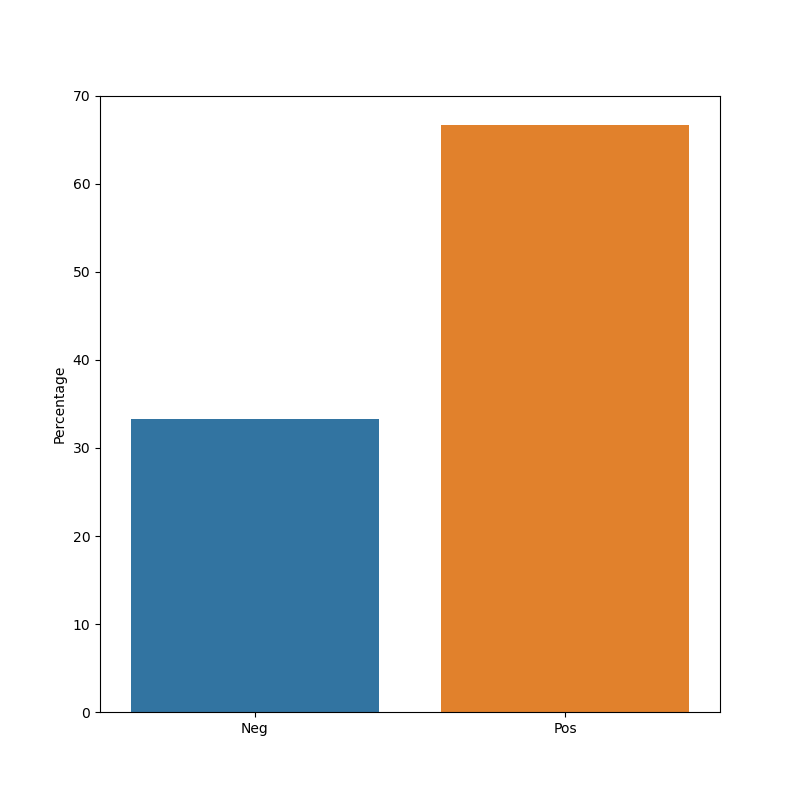

In [124]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

In [125]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_sentencedf[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].sentence)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].sentence)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
# print(scores)

channelName_to_scores = {}
for i in range(0, len(LIST_OF_CHANNEL_NAMES)):
    channelName_to_scores[LIST_OF_CHANNEL_NAMES[i]] = list(scores.values())[i]

avg_score=sum(channelName_to_scores.values())/len(LIST_OF_CHANNEL_NAMES)
print("avg score =", avg_score)
print(channelName_to_scores)
print(sorted(channelName_to_scores.items(), key=lambda item: item[1]))

avg score = 0.07597388354797363
{'Alex Clark': 0.12516857585575092, 'Alex Meyers': 0.101710173342626, 'WowRightMeow': 0.08816854174131132, 'Andrei Terbea': 0.06072288099989582, 'Billy But Better': 0.08979263685427905, 'Casually Explained': 0.07362420842944017, 'CircleToonsHD': 0.07858606456165129, 'CurtRichy': 0.08384791048467052, 'CypherDen': 0.06808188185542463, 'Daidus': 0.06898366486850935, 'DanPlan': 0.054978589239966985, 'Domics': 0.10238580477972715, 'Emirichu': 0.11027874248446, 'EroldStory': 0.11507509659290606, 'GradeAUnderA': 0.014606097560975638, 'GetMadz': 0.09165491091822814, 'GingerPale': 0.10900744269127717, 'Ice Cream Sandwich': 0.0910426470588234, 'illymation': 0.07580338454687165, 'Ivan Animated': 0.08914942616679404, 'Jaiden Animations': 0.08062958149207235, 'Let Me Explain Studios': 0.07389520283658355, 'Noodle': 0.06403156293222698, 'OverSimplified': -0.008489563758389364, 'TheOdd1sOut': 0.06449667373130859, 'PantslessPajamas': 0.073817246737104, 'SomeThingElseYT'

In [126]:
sorted_channelName_to_scores = dict(sorted(channelName_to_scores.items(), key=lambda item: item[1]))
sctsdf = pd.DataFrame.from_dict({'channelName':sorted_channelName_to_scores.keys(), 'scores': sorted_channelName_to_scores.values()})
sctsdf

,channelName,scores
0,OverSimplified,-0.008490
1,GradeAUnderA,0.014606
2,Tabbes,0.037002
3,DanPlan,0.054979
4,Andrei Terbea,0.060723
5,Noodle,0.064032
6,TheOdd1sOut,0.064497
7,Young Don The Sauce God,0.065815
8,Zalinki,0.066542
9,SomeThingElseYT,0.067470


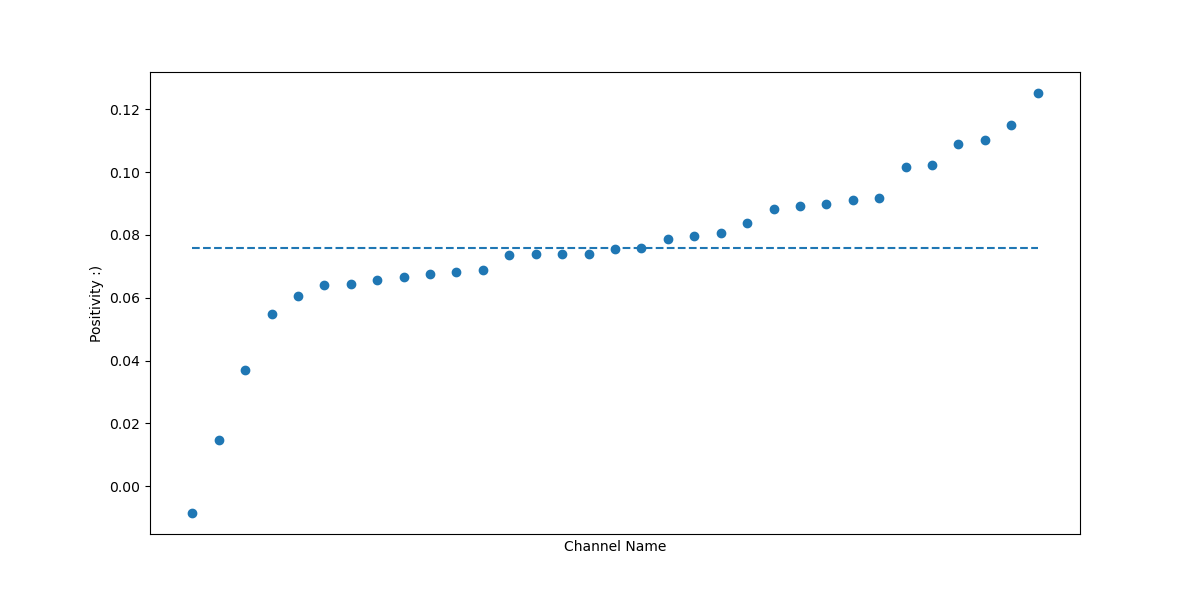

In [127]:
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
%matplotlib widget

x_name = "Channel Name"
y_name = "Positivity :)"
tooltip_name = "positivity value"

x= sctsdf['channelName']
y= sctsdf['scores']
tt = sctsdf['scores']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()


In [128]:
num_of_files = []
for channelId in LIST_OF_CHANNEL_IDS:
    num_of_files.append(len(os.listdir(channelId+"/txt/")))
 
cntvdf = pd.DataFrame.from_dict({'channelName':LIST_OF_CHANNEL_NAMES, 'number of transcripts collected': num_of_files, 'number of vids': LIST_OF_VIDEO_COUNT})

cntvdf

,channelName,number of transcripts collected,number of vids
0,Alex Clark,298,317
1,Alex Meyers,250,256
2,WowRightMeow,27,33
3,Andrei Terbea,112,136
4,Billy But Better,23,23
5,Casually Explained,80,81
6,CircleToonsHD,223,249
7,CurtRichy,89,97
8,CypherDen,58,63
9,Daidus,31,33


In [129]:
representation = sum(cntvdf['number of transcripts collected'])/sum(cntvdf['number of vids'])
print(representation)

0.8760815822002472


In [130]:
#https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
subsPerYearSinceFirstUpload = channelHolisticInfoDf['subscribersPerYearSinceFirstUpload']

In [131]:
zipped = zip(channelHolisticInfoDf.channelName, channelHolisticInfoDf.subscribersPerYearSinceFirstUpload)
sorted_channelName_to_rescaledSubs = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
sctrs = pd.DataFrame.from_dict({'channelName': sorted_channelName_to_rescaledSubs.keys(), 'rescaledSubCount': sorted_channelName_to_rescaledSubs.values()})
sctrs

,channelName,rescaledSubCount
0,Ivan Animated,2.420918e+04
1,Billy But Better,5.466590e+04
2,CurtRichy,6.226363e+04
3,Zalinki,7.179712e+04
4,GetMadz,8.528998e+04
5,WowRightMeow,1.083499e+05
6,Young Yong Tales,1.312173e+05
7,Noodle,1.324890e+05
8,PantslessPajamas,1.397693e+05
9,CypherDen,2.047628e+05


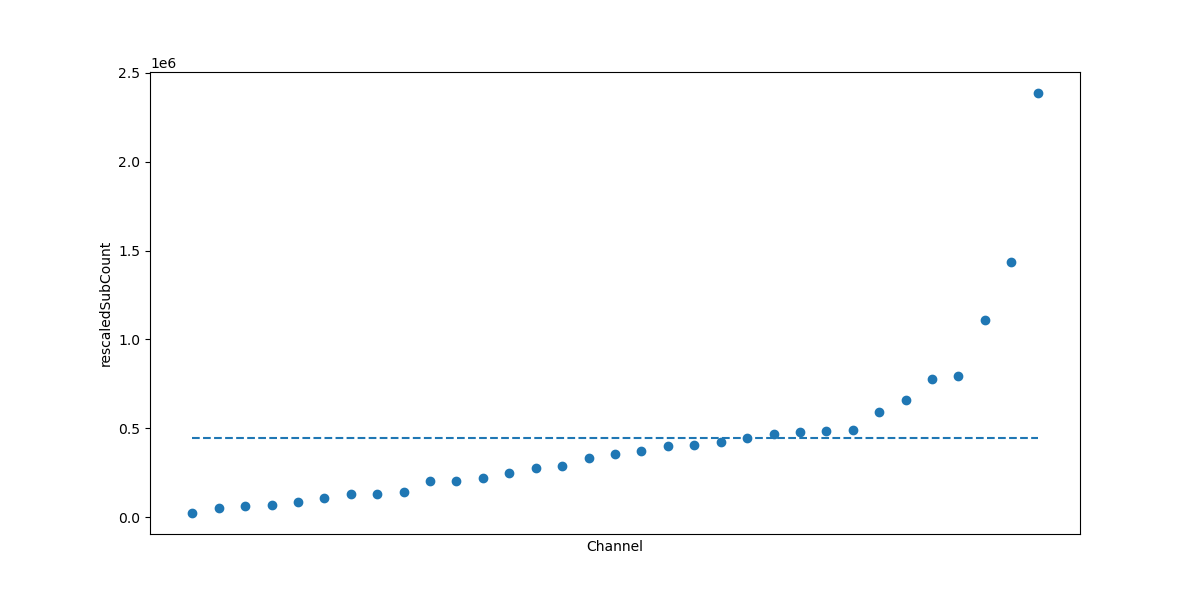

In [132]:
x_name = "Channel"
y_name = "rescaledSubCount"
tooltip_name = "subCountPerYearSinceFirstUpload"

x= sctrs['channelName']
y= sctrs['rescaledSubCount']
tt = sctrs['rescaledSubCount']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

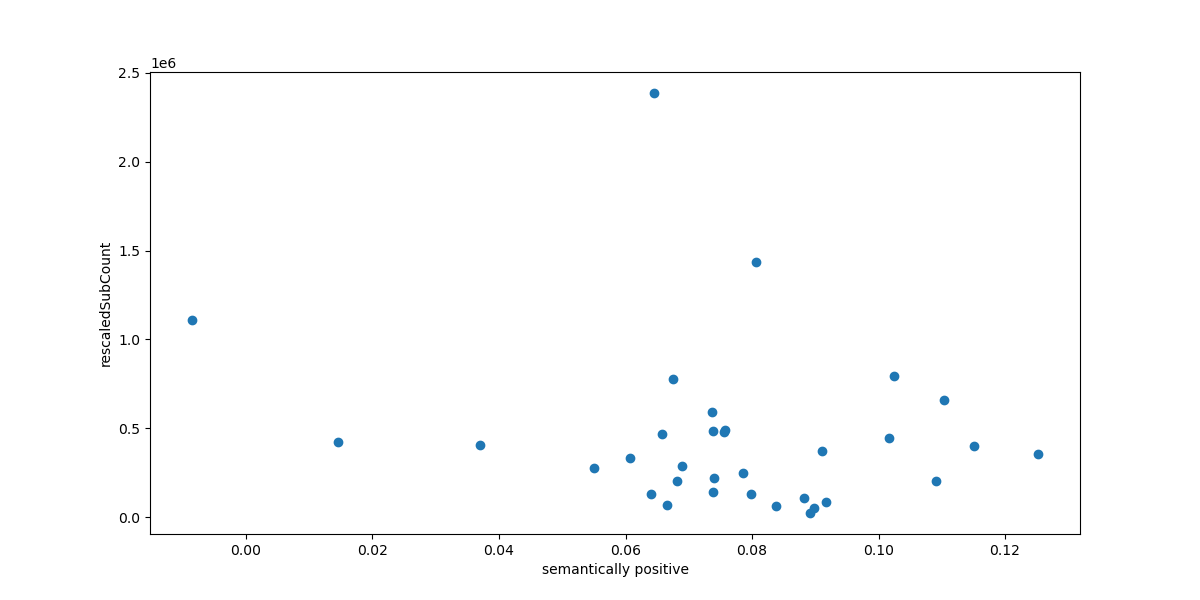

In [133]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
def generate_plot(semantic_df):
    x_name = "semantically positive"
    y_name = "rescaledSubCount"
    tooltip_name = "channelName"
    x= semantic_df['positivityScores']
    y= semantic_df['rescaledSubCount']
    tt = semantic_df[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
    # Plot the average line
    mean_x=np.arange(0,33,1)
    mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
    # mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details["positivityScores"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
generate_plot(semantic_df)

Pretty sure Oversimplified (and tbh, Odd1sOut) is messing up my calculations. 

In [134]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
semantic_df

,channelName,rescaledSubCount,positivityScores
0,Alex Clark,3.559353e+05,0.125169
1,Alex Meyers,4.474797e+05,0.101710
2,WowRightMeow,1.083499e+05,0.088169
3,Andrei Terbea,3.315021e+05,0.060723
4,Billy But Better,5.466590e+04,0.089793
5,Casually Explained,5.947656e+05,0.073624
6,CircleToonsHD,2.488131e+05,0.078586
7,CurtRichy,6.226363e+04,0.083848
8,CypherDen,2.047628e+05,0.068082
9,Daidus,2.907246e+05,0.068984


In [151]:
import numpy as np
import pandas as pd
outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    index =0
    for y in data_1:
        index+=1
        print(y)
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append((index, y))
    return outliers
print(detect_outlier(subsPerYearSinceFirstUpload))
print(detect_outlier(list(channelName_to_scores.values())))

355935.292777398
447479.7095258437
108349.91708126036
331502.06414734834
54665.89861751152
594765.5894401456
248813.14668289718
62263.63181590796
204762.80120481926
290724.5632065776
276700.1114827202
795293.2551319649
660246.3942307692
398214.28571428574
424898.0232193285
85289.97747747747
204976.76219984508
374313.05201177625
490756.3025210084
24209.183673469386
1432962.962962963
486132.4551774607
132489.0307140008
1106648.9361702127
2385800.15026296
139769.3194925029
780138.390568939
477540.6152782579
404766.53696498054
223144.10480349345
470000.0
131217.29237770193
71797.11637487127
[2385800.15026296]
0.12516857585575092
0.101710173342626
0.08816854174131132
0.06072288099989582
0.08979263685427905
0.07362420842944017
0.07858606456165129
0.08384791048467052
0.06808188185542463
0.06898366486850935
0.054978589239966985
0.10238580477972715
0.11027874248446
0.11507509659290606
0.014606097560975638
0.09165491091822814
0.10900744269127717
0.0910426470588234
0.07580338454687165
0.089149426

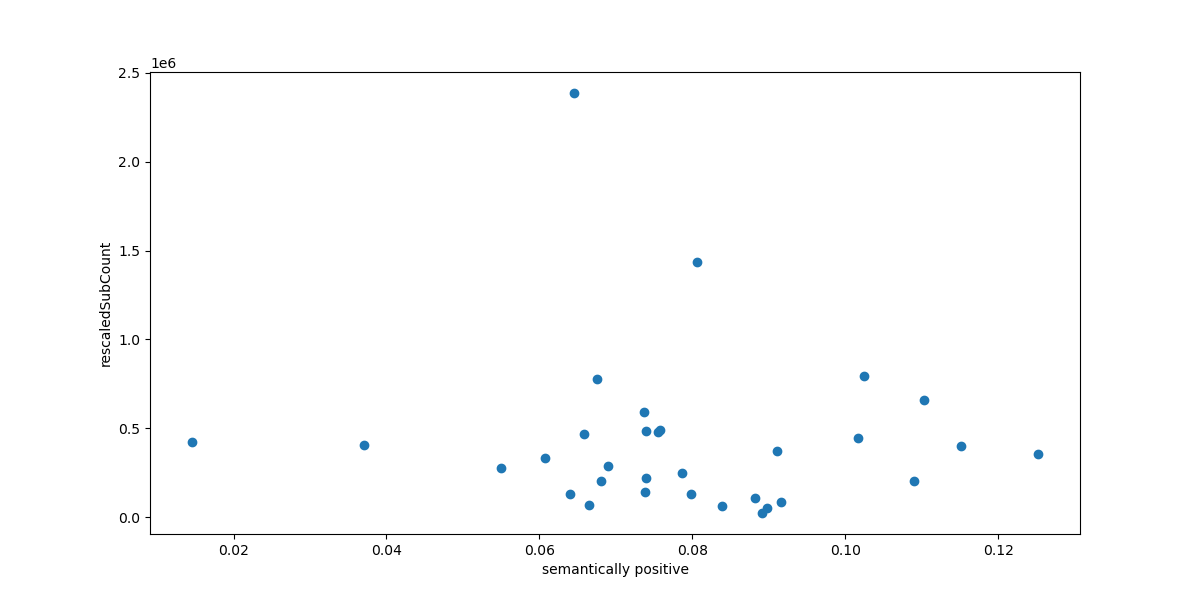

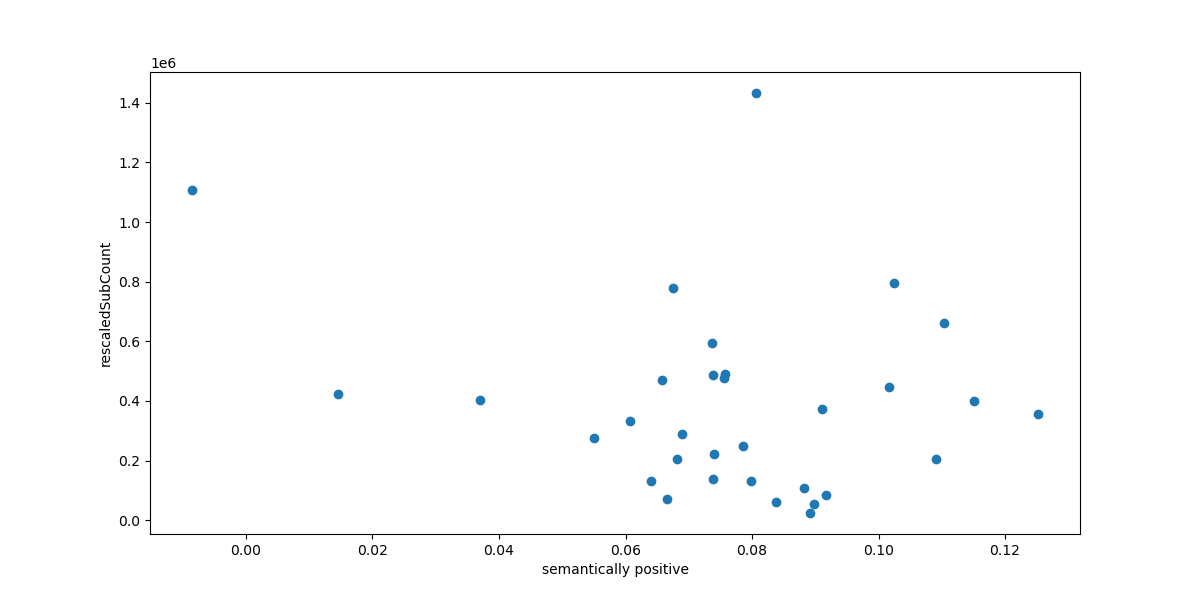

In [137]:
copy_without_oversimplified = semantic_df.drop('23')
copy_without_odd1sout = semantic_df.drop(['24'])
semantic_df_copy_without_oversimplified = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_oversimplified.to_dict())))
semantic_df_copy_without_odd1sout = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_odd1sout.to_dict())))

generate_plot(semantic_df_copy_without_oversimplified)
generate_plot(semantic_df_copy_without_odd1sout)

So how exactly strong is the correlation? If it's close to 0, then literally, there's no relationship between how positive a channel is. 

In [138]:
import numpy as np
import scipy.stats
x= 'rescaledSubCount'	
y= 'positivityScores'
result = scipy.stats.linregress(semantic_df[x], semantic_df[y])
result_no_oversimplified = scipy.stats.linregress(semantic_df_copy_without_oversimplified[x], semantic_df_copy_without_oversimplified[y])
result_no_odd1sout = scipy.stats.linregress(semantic_df_copy_without_odd1sout[x], semantic_df_copy_without_odd1sout[y])

print(result.rvalue)
print(result_no_oversimplified.rvalue)
print(result_no_odd1sout.rvalue)

-0.2071749572877416
-0.07678611344603309
-0.22544545509330252
